<a href="https://colab.research.google.com/github/jumafernandez/clasificacion_correos/blob/main/notebooks/jaiio/03-modelos/01-etiquetado_manual%2Bsvm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline JAIIO: Etiquetado manual+SVM

En esta notebook se presetan los experimentos sobre la estrategia de representación y técnica de aprendizaje *baseline* utilizada para JAIIO con los correos etiquetados de forma manual.

Para ello vamos a preprocesar los correos y aplicar:
- Bag of words,
- Pesado binario/no binario,
- Máquina de vector soporte (SVM).


## 1. Instalación y Carga de librerías y funciones útiles

### 1.1 Instalación de librerías

Se instalan las librerías que no están en el entorno de Google Colab:

In [1]:
# Se instala gensim que es el que tiene el modelo Word2Vec
!pip install requests
!pip install wget

### 1.2 Funciones útiles

Se cargan funciones útiles desde el repo https://github.com/jumafernandez/clasificacion_correos para la carga y balanceo del dataset.

In [2]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_dataset.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_dataset.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_dataset import get_clases, cargar_dataset, consolidar_df

También se carga la función para preprocesar el texto que se usó en los otros modelos desde el repo: https://github.com/jumafernandez/clasificacion_correos.

In [3]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_preprocesamiento.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_preprocesamiento.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_preprocesamiento import preprocesar_correos

### 1.3. Carga de datos

Se carga el dataframe en memoria con el preprocesamiento de los datos:

In [4]:
import warnings
from os import path
warnings.filterwarnings("ignore")

# Constantes con los datos
DS_DIR = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/50jaiio/consolidados/'
TRAIN_FILE = 'correos-train-jaiio-80.csv'
TEST_FILE = 'correos-test-jaiio-20.csv'

# Chequeo sobre si los archivos están en el working directory
download_files = not(path.exists(TRAIN_FILE))

etiquetas = get_clases()

# Defino la cantidad de clases a utilizar
CANTIDAD_CLASES = len(etiquetas)

train_df, test_df, etiquetas = cargar_dataset(DS_DIR, TRAIN_FILE, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')

# Se ejecuta el preprocesamiento de correos sobre el campo Consulta de train y test
import pandas as pd
train_df['consulta'] = pd.Series(preprocesar_correos(train_df['consulta']))
test_df['consulta'] = pd.Series(preprocesar_correos(test_df['consulta']))

# Muestro salida por consola
print('Existen {} clases: {}.'.format(len(train_df.clase.unique()), train_df.clase.unique()))


El conjunto de entrenamiento tiene la dimensión: (800, 24)
El conjunto de testeo tiene la dimensión: (200, 24)
Existen 16 clases: ['Boleto Universitario' 'Problemas con la Clave' 'Cursadas'
 'Cambio de Carrera' 'Ingreso a la Universidad' 'Requisitos de Ingreso'
 'Reincorporación' 'Pedido de Certificados' 'Situación Académica'
 'Exámenes' 'Cambio de Comisión' 'Consulta por Legajo'
 'Consulta sobre Título Universitario' 'Datos Personales'
 'Consulta por Equivalencias' 'Simultaneidad de Carreras'].


## 2. SVM

### 2.1. Carga de librerías de procesamiento de texto

Se cargan en memoria dos funciones: _grid_search_por_estrategia_representacion_ que va a iterar ajustando los hiperparámetros para las técnica de __SVM__ y _representacion_documentos_ que genera representaciones para las _features textuales_:

In [5]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_clasificacion_texto.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_clasificacion_texto.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_clasificacion_texto import gridsearch_por_estrategia_representacion, representacion_documentos

### 2.2 Modelo general (clasificación en las 16 clases)

En primer lugar se trabaja con un único clasificador que clasifica y testea las instancias en las 16 clases posibles.

#### 2.2.1 Definición del espacio de búsqueda

Se define el espacio de búsqueda para el ajuste de hiperparámetros del modelo:

In [6]:
# Defino una lista con los esquemas de representación
estrategias_representacion = ['BINARIO', 'TFIDF', '3-4-NGRAM-CHARS', '1-2-NGRAM-WORDS']
modelo = 'SVM'

# Defino los parámetros para GridSearchCV
params_svm = {'SVM__C': [0.1, 1, 10, 100], 
              'SVM__gamma': [0.01, 0.1, 1],
              'SVM__class_weight': [None, 'balanced'],
              'SVM__kernel': ['rbf', 'linear', 'poly', 'sigmoid']
              }

Se ejecuta el ajuste de hiperparámetros para cada estrategia de representación en función del espacio de búsqueda:

In [7]:
NO_CORRIDA = False

if NO_CORRIDA:
  for estrategia in estrategias_representacion:
    # Llamo a la función que realiza el gridsearch por estrategia  
    gridsearch_por_estrategia_representacion(train_df, test_df, estrategia, modelo, params_svm, None, atr_consulta='consulta')

#### 2.2.2 Modelo generado

En función de los mejores hiperparámetros encontrados con la búsqueda Grid, ajusto el modelo para obtener las métricas (por un bug en la función ya solucionado):

In [8]:
# Mejores Parámetros según GridSearchCV:
# {'SVM__C': 10, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.01, 'SVM__kernel': 'sigmoid', 'estrategia': '3-4-NGRAM-CHARS', 
#  'accuracy': 0.81, 'precision': 0.5971321956813028, 'recall': 0.553190280233687, 'f1_score': 0.5639032258154839}

params_svm = {'SVM__C': [10], 
              'SVM__gamma': [0.01],
              'SVM__class_weight': ['balanced'],
              'SVM__kernel': ['sigmoid'],
              'SVM__probability': [True]
              }

clf, X_test, y_test = gridsearch_por_estrategia_representacion(train_df, test_df, '3-4-NGRAM-CHARS', 'SVM', params_svm, None, atr_consulta='consulta')

Estrategia de representación: 3-4-NGRAM-CHARS
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min finished


Estrategia de representación: 3-4-NGRAM-CHARS
Parámetros: {'SVM__C': 10, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.01, 'SVM__kernel': 'sigmoid', 'SVM__probability': True, 'clasificador': 'SVM', 'estrategia': '3-4-NGRAM-CHARS', 'accuracy': 0.81, 'precision': 0.8200216321377036, 'recall': 0.81, 'f1_score': 0.8054753214306736}
Accuracy Test-Set: 0.81
Métricas sobre Test-Set: {'SVM__C': 10, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.01, 'SVM__kernel': 'sigmoid', 'SVM__probability': True, 'clasificador': 'SVM', 'estrategia': '3-4-NGRAM-CHARS', 'accuracy': 0.81, 'precision': 0.8200216321377036, 'recall': 0.81, 'f1_score': 0.8054753214306736}


Se predicen las instancias de testeo:

In [9]:
y_pred = clf.predict(X_test)

Además, se utiliza el método _predict\_proba_ para calcular la probabilidad asociada a la clasificación de cada instancia:

In [10]:
import numpy as np

y_pred_proba = np.around(clf.predict_proba(X_test), 2)

y_max_proba = np.amax(y_pred_proba, 1)

In [11]:
y_max_proba

array([0.99, 0.77, 0.27, 0.44, 0.72, 0.89, 0.37, 0.75, 0.61, 0.34, 0.88,
       0.47, 0.93, 0.63, 0.95, 0.85, 0.4 , 0.98, 0.85, 0.53, 0.28, 0.35,
       0.97, 0.45, 0.6 , 0.87, 0.23, 0.68, 0.87, 0.94, 0.49, 0.72, 0.89,
       0.96, 0.45, 0.47, 0.94, 0.89, 0.98, 0.86, 0.99, 0.51, 0.64, 0.46,
       0.92, 0.99, 0.42, 0.64, 0.92, 0.79, 0.62, 0.17, 1.  , 0.99, 0.45,
       0.71, 0.92, 0.97, 0.93, 0.85, 0.67, 1.  , 1.  , 1.  , 0.7 , 0.87,
       0.66, 0.47, 0.98, 0.39, 0.69, 0.98, 0.98, 0.54, 0.83, 0.43, 0.68,
       0.98, 0.56, 0.93, 0.88, 0.67, 0.94, 0.82, 0.82, 0.92, 0.87, 0.88,
       0.4 , 0.93, 0.7 , 0.67, 0.44, 0.69, 0.54, 0.62, 0.63, 0.98, 0.92,
       0.81, 0.97, 0.44, 0.34, 0.43, 0.99, 0.89, 0.38, 0.93, 0.86, 0.47,
       0.95, 0.9 , 0.68, 0.4 , 0.89, 0.94, 0.94, 0.94, 0.93, 0.47, 0.92,
       0.41, 0.76, 0.5 , 0.74, 0.95, 0.57, 0.56, 0.87, 0.98, 0.97, 0.33,
       0.86, 0.9 , 0.98, 0.33, 0.85, 0.84, 0.3 , 0.27, 0.2 , 0.55, 1.  ,
       0.51, 0.99, 0.96, 0.24, 0.57, 0.31, 0.82, 0.

Se genera un _dataframe_ con las clases observadas para _test_, las predicciones y las probabilidades asociadas para verificar si hay relación entre las proba y los errores:

In [12]:
import pandas as pd

resultados = pd.concat([pd.Series(y_test), pd.Series(y_pred), pd.Series(y_max_proba)], axis=1)
resultados.columns = ['clase', 'prediccion', 'max_proba']
resultados['correcto'] = resultados['clase'] == resultados['prediccion']

Se calcula el _accuracy__ para las predicciones con una proba>0.5 y se obtiene una mejora sustancial:

In [13]:
sum(resultados[resultados.max_proba>0.5]['correcto'])/resultados[resultados.max_proba>0.5]['correcto'].count()

0.896774193548387

#### 2.2.3 Métricas de selección

##### 2.2.3.1. Matriz de confusión

A continuación, se calcula la matriz de confusión para cada clase para el recorte con proba>0.5 y para el modelo con la totalidad de instancias:

In [14]:
from sklearn import metrics #Importar el módulo metrics de scikit-learn

# Vamos a testear el modelo
print("Accuracy:", metrics.accuracy_score(resultados[resultados.max_proba>0.5]['clase'], resultados[resultados.max_proba>0.5]['prediccion']))

# Vemos un reporte de clasificación de varias métricas
print(metrics.classification_report(resultados[resultados.max_proba>0.5]['clase'], resultados[resultados.max_proba>0.5]['prediccion']))

Accuracy: 0.896774193548387
                                     precision    recall  f1-score   support

               Boleto Universitario       1.00      0.98      0.99        46
                  Cambio de Carrera       0.00      0.00      0.00         0
         Consulta por Equivalencias       1.00      1.00      1.00         1
                Consulta por Legajo       0.67      1.00      0.80         2
Consulta sobre Título Universitario       1.00      1.00      1.00         1
                           Cursadas       0.83      0.83      0.83        12
                   Datos Personales       0.00      0.00      0.00         1
                           Exámenes       1.00      1.00      1.00         3
           Ingreso a la Universidad       0.91      0.81      0.86        26
             Pedido de Certificados       0.93      1.00      0.97        14
             Problemas con la Clave       0.90      0.95      0.92        19
                    Reincorporación       0.75 

In [15]:
from sklearn import metrics #Importar el módulo metrics de scikit-learn

# Vamos a testear el modelo
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Vemos un reporte de clasificación de varias métricas
print(metrics.classification_report(y_test, y_pred))

Accuracy: 0.81
                                     precision    recall  f1-score   support

               Boleto Universitario       0.96      0.98      0.97        48
                  Cambio de Carrera       0.00      0.00      0.00         2
                 Cambio de Comisión       0.00      0.00      0.00         2
         Consulta por Equivalencias       1.00      0.67      0.80         3
                Consulta por Legajo       0.67      0.67      0.67         3
Consulta sobre Título Universitario       0.50      0.33      0.40         3
                           Cursadas       0.49      0.89      0.63        19
                   Datos Personales       0.00      0.00      0.00         2
                           Exámenes       1.00      0.60      0.75         5
           Ingreso a la Universidad       0.93      0.79      0.85        33
             Pedido de Certificados       0.94      1.00      0.97        15
             Problemas con la Clave       0.91      0.87    

In [16]:
metrics.confusion_matrix(y_test, y_pred)

array([[47,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  2,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 2,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0, 17,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  3,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  2,  0,  0, 26,  1,  1,  1,  2,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 15,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0, 20,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0,  7,  1,  0,  1],
       [ 0,  0,  0,  0,  0,  1,  4,  0,  0,  0,  0,

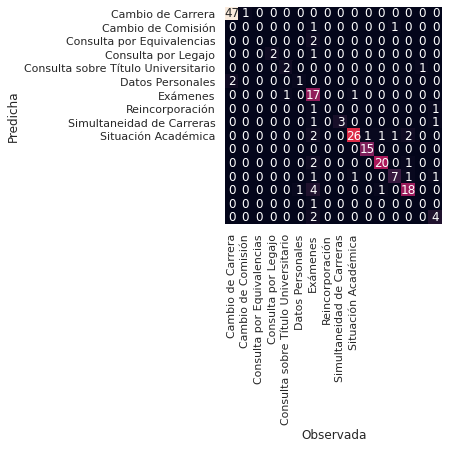

In [60]:
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

mat_clf = metrics.confusion_matrix(y_test, y_pred)

sns.heatmap(mat_clf, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=etiquetas, yticklabels=etiquetas)

plt.xlabel('Observada')
plt.ylabel('Predicha');

### 2.3 Modelo en cascada

En segundo lugar se avanza en un modelo de clasificación en cascada, primero clasificando las clases más populosas y luego clasificando, con un segundo clasificador, el resto.

#### 2.3.1 Re-etiquetado de instancias

Se re-etiquetan las instancias, dejando la clase para las N más pobladas y definiendo como 'Otras Consultas' en el resto para armar un segundo clasificador:

Se verifica la cantidad de ejemplos por clase para train_df:

In [18]:
train_df.clase.value_counts()

Boleto Universitario                   193
Ingreso a la Universidad               135
Requisitos de Ingreso                   98
Problemas con la Clave                  91
Cursadas                                75
Pedido de Certificados                  59
Reincorporación                         43
Situación Académica                     22
Exámenes                                18
Consulta por Legajo                     15
Cambio de Carrera                       11
Consulta por Equivalencias              10
Consulta sobre Título Universitario     10
Cambio de Comisión                       8
Datos Personales                         6
Simultaneidad de Carreras                6
Name: clase, dtype: int64

En función de la info anterior, definimos el N de la cantidad de clases a conservar:

In [19]:
N_clases=7

In [20]:
def comprimir_clases(df, atr_clase, cantidad, text_agr):
  '''
  Esta función recibe un dataframe, con el atributo clase y agrupa las clases menos
  presentes en una única etiqueta text_agr
  '''
  clases = df[atr_clase].value_counts()
  clases_minoritarias = clases.iloc[cantidad-1:].keys().to_list()
  print(f'Las clases a agrupar son: {clases_minoritarias}')

  # Recupero las diferentes clases y a la etiqueta text_agr para el agrupamiento
  class_labels = clases.keys().to_list()
  class_labels = np.append(class_labels, text_agr)
  
  # Genero una nueva clave de clases para text_agr a modo de agrupar las que poseen menos apariciones
  df[atr_clase][df[atr_clase].isin(clases_minoritarias)] = text_agr

  return df

In [21]:
train_df_cascada = comprimir_clases(train_df.copy(), atr_clase='clase', cantidad=N_clases, text_agr='Otras Consultas')
test_df_cascada = comprimir_clases(test_df.copy(), atr_clase='clase', cantidad=N_clases, text_agr='Otras Consultas')

Las clases a agrupar son: ['Reincorporación', 'Situación Académica', 'Exámenes', 'Consulta por Legajo', 'Cambio de Carrera', 'Consulta por Equivalencias', 'Consulta sobre Título Universitario', 'Cambio de Comisión', 'Datos Personales', 'Simultaneidad de Carreras']
Las clases a agrupar son: ['Reincorporación', 'Situación Académica', 'Exámenes', 'Consulta por Legajo', 'Consulta sobre Título Universitario', 'Consulta por Equivalencias', 'Cambio de Carrera', 'Datos Personales', 'Cambio de Comisión', 'Simultaneidad de Carreras']


In [22]:
train_df_cascada.clase.value_counts()

Boleto Universitario        193
Otras Consultas             149
Ingreso a la Universidad    135
Requisitos de Ingreso        98
Problemas con la Clave       91
Cursadas                     75
Pedido de Certificados       59
Name: clase, dtype: int64

#### 2.3.2 Generación del Modelo (1er nivel de cascada)

##### 2.3.2.1 Definición del espacio de búsqueda (1er nivel de cascada)

Se define el espacio de búsqueda para el ajuste de hiperparámetros del modelo:

In [23]:
# Defino una lista con los esquemas de representación
estrategias_representacion = ['BINARIO', 'TFIDF', '3-4-NGRAM-CHARS', '1-2-NGRAM-WORDS']
modelo = 'SVM'

# Defino los parámetros para GridSearchCV
params_svm = {'SVM__C': [0.1, 1, 10, 100], 
              'SVM__gamma': [0.01, 0.1, 1],
              'SVM__class_weight': [None, 'balanced'],
              'SVM__kernel': ['rbf', 'linear', 'poly', 'sigmoid']
              }

Se ejecuta el ajuste de hiperparámetros para cada estrategia de representación en función del espacio de búsqueda:

In [24]:
NO_CORRIDA = False

if NO_CORRIDA:
  for estrategia in estrategias_representacion:
    # Llamo a la función que realiza el gridsearch por estrategia  
    gridsearch_por_estrategia_representacion(train_df_cascada, test_df_cascada, estrategia, modelo, params_svm, None, atr_consulta='consulta')

##### 2.3.2.2 Modelo generado (1er nivel)

En función de los mejores hiperparámetros encontrados con la búsqueda Grid, ajusto el modelo para obtener las métricas (por un bug en la función ya solucionado):

In [25]:
# Mejores Parámetros según GridSearchCV:
# {'SVM__C': 10, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.01, 'SVM__kernel': 'sigmoid', 'estrategia': '3-4-NGRAM-CHARS', 
#  'accuracy': 0.81, 'precision': 0.5971321956813028, 'recall': 0.553190280233687, 'f1_score': 0.5639032258154839}

params_svm = {'SVM__C': [10], 
              'SVM__gamma': [0.01],
              'SVM__class_weight': ['balanced'],
              'SVM__kernel': ['sigmoid'],
              'SVM__probability': [False]
              }

clf_cascada_1, X_test_cascada, y_test_cascada = gridsearch_por_estrategia_representacion(train_df_cascada, test_df_cascada, '3-4-NGRAM-CHARS', 'SVM', params_svm, None, atr_consulta='consulta')

Estrategia de representación: 3-4-NGRAM-CHARS
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.6s finished


Estrategia de representación: 3-4-NGRAM-CHARS
Parámetros: {'SVM__C': 10, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.01, 'SVM__kernel': 'sigmoid', 'SVM__probability': False, 'clasificador': 'SVM', 'estrategia': '3-4-NGRAM-CHARS', 'accuracy': 0.875, 'precision': 0.8893016426656132, 'recall': 0.875, 'f1_score': 0.8782021272667353}
Accuracy Test-Set: 0.875
Métricas sobre Test-Set: {'SVM__C': 10, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.01, 'SVM__kernel': 'sigmoid', 'SVM__probability': False, 'clasificador': 'SVM', 'estrategia': '3-4-NGRAM-CHARS', 'accuracy': 0.875, 'precision': 0.8893016426656132, 'recall': 0.875, 'f1_score': 0.8782021272667353}


Se predicen las instancias de testeo:

In [26]:
y_pred_cascada = clf_cascada_1.predict(X_test_cascada)

In [27]:
from sklearn import metrics #Importar el módulo metrics de scikit-learn

# Vamos a testear el modelo
print("Accuracy:",metrics.accuracy_score(y_test_cascada, y_pred_cascada))

# Vemos un reporte de clasificación de varias métricas
print(metrics.classification_report(y_test_cascada, y_pred_cascada))

Accuracy: 0.875
                          precision    recall  f1-score   support

    Boleto Universitario       1.00      1.00      1.00        48
                Cursadas       0.59      0.84      0.70        19
Ingreso a la Universidad       0.93      0.79      0.85        33
         Otras Consultas       0.88      0.79      0.83        38
  Pedido de Certificados       0.94      1.00      0.97        15
  Problemas con la Clave       0.95      0.87      0.91        23
   Requisitos de Ingreso       0.77      0.83      0.80        24

                accuracy                           0.88       200
               macro avg       0.87      0.87      0.87       200
            weighted avg       0.89      0.88      0.88       200



#### 2.3.3 Generación del Modelo (2do nivel de cascada)

##### 2.3.3.1 Separación de datos con clases agrupadas

Ahora se seleccionan solo las instancias de las clases que antes habíamos agrupado en 'Otras Consultas':

In [28]:
# Me traigo el dataframe del primer modelo (con todas las clases)
# y le agrego la clase agrupada en el 1er nivel de cascada
train_aux = train_df.copy()
train_aux['clase_cascada_1'] = train_df_cascada['clase']

# Filtro las instancias que tenían el valor 'Otras Consultas' para generar 
# el clasificador de 2do nivel con esas
# Luego elimino la columna que usé para identificar los agrupamientos
train_df_cascada_2 = train_aux.query("clase_cascada_1 == 'Otras Consultas'").reset_index()
train_df_cascada_2.drop(['clase_cascada_1'], inplace=True, axis=1)

train_df_cascada_2.shape

(149, 25)

Hago lo mismo para el set de test:

In [29]:
# Me traigo el dataframe del primer modelo (con todas las clases)
# y le agrego la clase agrupada en el 1er nivel de cascada
test_aux = test_df.copy()
test_aux['clase_cascada_1'] = test_df_cascada['clase']

# Filtro las instancias que tenían el valor 'Otras Consultas' para generar 
# el clasificador de 2do nivel con esas
# Luego elimino la columna que usé para identificar los agrupamientos
test_df_cascada_2 = test_aux.query("clase_cascada_1 == 'Otras Consultas'").reset_index()
test_df_cascada_2.drop(['clase_cascada_1'], inplace=True, axis=1)

test_df_cascada_2.shape

(38, 25)

##### 2.3.3.2 Definición del espacio de búsqueda (2do nivel de cascada)

Se define el espacio de búsqueda para el ajuste de hiperparámetros del modelo:

In [30]:
# Defino una lista con los esquemas de representación
estrategias_representacion = ['BINARIO', 'TFIDF', '3-4-NGRAM-CHARS', '1-2-NGRAM-WORDS']
modelo = 'SVM'

# Defino los parámetros para GridSearchCV
params_svm = {'SVM__C': [0.1, 1, 10, 100], 
              'SVM__gamma': [0.01, 0.1, 1],
              'SVM__class_weight': [None, 'balanced'],
              'SVM__kernel': ['rbf', 'linear', 'poly', 'sigmoid']
              }

Se ejecuta el ajuste de hiperparámetros para cada estrategia de representación en función del espacio de búsqueda:

In [31]:
NO_CORRIDA = False

if NO_CORRIDA:
  for estrategia in estrategias_representacion:
    # Llamo a la función que realiza el gridsearch por estrategia  
    gridsearch_por_estrategia_representacion(train_df_cascada_2, test_df_cascada_2, estrategia, modelo, params_svm, None, atr_consulta='consulta')

Estrategia de representación: BINARIO
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 476 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   13.5s finished


Estrategia de representación: BINARIO
Parámetros: {'SVM__C': 0.1, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.01, 'SVM__kernel': 'linear', 'clasificador': 'SVM', 'estrategia': 'BINARIO', 'accuracy': 0.5263157894736842, 'precision': 0.4973684210526315, 'recall': 0.5263157894736842, 'f1_score': 0.4783840098780676}
Accuracy Test-Set: 0.5263157894736842
Métricas sobre Test-Set: {'SVM__C': 0.1, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.01, 'SVM__kernel': 'linear', 'clasificador': 'SVM', 'estrategia': 'BINARIO', 'accuracy': 0.5263157894736842, 'precision': 0.4973684210526315, 'recall': 0.5263157894736842, 'f1_score': 0.4783840098780676}
Estrategia de representación: TFIDF
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 476 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   13.6s finished


Estrategia de representación: TFIDF
Parámetros: {'SVM__C': 100, 'SVM__class_weight': None, 'SVM__gamma': 0.1, 'SVM__kernel': 'sigmoid', 'clasificador': 'SVM', 'estrategia': 'TFIDF', 'accuracy': 0.5526315789473685, 'precision': 0.5426065162907269, 'recall': 0.5526315789473685, 'f1_score': 0.5338619275461381}
Accuracy Test-Set: 0.5526315789473685
Métricas sobre Test-Set: {'SVM__C': 100, 'SVM__class_weight': None, 'SVM__gamma': 0.1, 'SVM__kernel': 'sigmoid', 'clasificador': 'SVM', 'estrategia': 'TFIDF', 'accuracy': 0.5526315789473685, 'precision': 0.5426065162907269, 'recall': 0.5526315789473685, 'f1_score': 0.5338619275461381}
Estrategia de representación: 3-4-NGRAM-CHARS
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  1.3min finished


Estrategia de representación: 3-4-NGRAM-CHARS
Parámetros: {'SVM__C': 1, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.01, 'SVM__kernel': 'sigmoid', 'clasificador': 'SVM', 'estrategia': '3-4-NGRAM-CHARS', 'accuracy': 0.6578947368421053, 'precision': 0.6428571428571429, 'recall': 0.6578947368421053, 'f1_score': 0.6412955465587045}
Accuracy Test-Set: 0.6578947368421053
Métricas sobre Test-Set: {'SVM__C': 1, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.01, 'SVM__kernel': 'sigmoid', 'clasificador': 'SVM', 'estrategia': '3-4-NGRAM-CHARS', 'accuracy': 0.6578947368421053, 'precision': 0.6428571428571429, 'recall': 0.6578947368421053, 'f1_score': 0.6412955465587045}
Estrategia de representación: 1-2-NGRAM-WORDS
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 244 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   40.2s finished


Estrategia de representación: 1-2-NGRAM-WORDS
Parámetros: {'SVM__C': 1, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.1, 'SVM__kernel': 'sigmoid', 'clasificador': 'SVM', 'estrategia': '1-2-NGRAM-WORDS', 'accuracy': 0.5263157894736842, 'precision': 0.5609649122807019, 'recall': 0.5263157894736842, 'f1_score': 0.5163016236242781}
Accuracy Test-Set: 0.5263157894736842
Métricas sobre Test-Set: {'SVM__C': 1, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.1, 'SVM__kernel': 'sigmoid', 'clasificador': 'SVM', 'estrategia': '1-2-NGRAM-WORDS', 'accuracy': 0.5263157894736842, 'precision': 0.5609649122807019, 'recall': 0.5263157894736842, 'f1_score': 0.5163016236242781}


##### 2.3.3.3 Modelo generado (2do nivel)

En función de los mejores hiperparámetros encontrados con la búsqueda Grid, ajusto el modelo para obtener las métricas:

In [38]:
# Mejores Parámetros según GridSearchCV:
# Métricas sobre Test-Set: {'SVM__C': 1, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.1, 'SVM__kernel': 'sigmoid',
# 'clasificador': 'SVM', 'estrategia': '1-2-NGRAM-WORDS', 'accuracy': 0.5263157894736842, 'precision': 0.45666666666666667, 
# 'recall': 0.4203030303030303, 'f1_score': 0.4146790890269151}
# Métricas sobre Test-Set: {'SVM__C': 1, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.01, 'SVM__kernel': 'sigmoid', 'clasificador': 'SVM', 'estrategia': '3-4-NGRAM-CHARS', 'accuracy': 0.6578947368421053, 'precision': 0.6428571428571429, 'recall': 0.6578947368421053, 'f1_score': 0.6412955465587045}

params_svm = {'SVM__C': [1], 
              'SVM__gamma': [0.01],
              'SVM__class_weight': ['balanced'],
              'SVM__kernel': ['sigmoid'],
              'SVM__probability': [False]
              }

clf_cascada_2, X_test_cascada_2, y_test_cascada_2 = gridsearch_por_estrategia_representacion(train_df_cascada_2, test_df_cascada_2, '3-4-NGRAM-CHARS', 'SVM', params_svm, None, atr_consulta='consulta')

Estrategia de representación: 3-4-NGRAM-CHARS
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Estrategia de representación: 3-4-NGRAM-CHARS
Parámetros: {'SVM__C': 1, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.01, 'SVM__kernel': 'sigmoid', 'SVM__probability': False, 'clasificador': 'SVM', 'estrategia': '3-4-NGRAM-CHARS', 'accuracy': 0.6578947368421053, 'precision': 0.6428571428571429, 'recall': 0.6578947368421053, 'f1_score': 0.6412955465587045}
Accuracy Test-Set: 0.6578947368421053
Métricas sobre Test-Set: {'SVM__C': 1, 'SVM__class_weight': 'balanced', 'SVM__gamma': 0.01, 'SVM__kernel': 'sigmoid', 'SVM__probability': False, 'clasificador': 'SVM', 'estrategia': '3-4-NGRAM-CHARS', 'accuracy': 0.6578947368421053, 'precision': 0.6428571428571429, 'recall': 0.6578947368421053, 'f1_score': 0.6412955465587045}


Se predicen las instancias de testeo:

In [39]:
y_pred_cascada_2 = clf_cascada_2.predict(X_test_cascada_2)

In [40]:
from sklearn import metrics #Importar el módulo metrics de scikit-learn

# Vamos a testear el modelo
print("Accuracy:",metrics.accuracy_score(y_test_cascada_2, y_pred_cascada_2))

# Vemos un reporte de clasificación de varias métricas
print(metrics.classification_report(y_test_cascada_2, y_pred_cascada_2))

Accuracy: 0.6578947368421053
                                     precision    recall  f1-score   support

                  Cambio de Carrera       0.50      0.50      0.50         2
                 Cambio de Comisión       1.00      1.00      1.00         2
         Consulta por Equivalencias       1.00      0.67      0.80         3
                Consulta por Legajo       1.00      0.67      0.80         3
Consulta sobre Título Universitario       1.00      1.00      1.00         3
                   Datos Personales       0.00      0.00      0.00         2
                           Exámenes       0.40      0.40      0.40         5
                    Reincorporación       0.71      0.91      0.80        11
          Simultaneidad de Carreras       0.00      0.00      0.00         1
                Situación Académica       0.43      0.50      0.46         6

                           accuracy                           0.66        38
                          macro avg       0.6

In [41]:
pd.set_option('display.max_colwidth', None)

# Se define una clase a explorar test vs pred
clase = 'Reincorporación'

# Se buscan las instancias de esa clase y se construye un dataframe:
# | consulta | clase | clase_predicha |
id_query = np.where(y_test_cascada_2 == clase)[0]

df_test_val = test_df_cascada_2.iloc[id_query,:][['consulta', 'clase']].reset_index()
df_test_val['clase_predicha'] = pd.Series(y_pred_cascada_2[id_query])

In [36]:
df_test_val

,index,consulta,clase,clase_predicha
0,4,hola queria consultarles razon perdi regularidad despues tiempo poder ir universidad re inscribi finales 2017 comence 2018 pude cursar par materias dejar tiempo estudio espero respuesta respuesta via mail mejor trabajando 8 muchas gracias matias,Reincorporación,Reincorporación
1,6,hacer reinscribirme poder comenzar segundo semestre,Reincorporación,Reincorporación
2,10,buen dia deseo obtener informacion situacion academica deseo ano proximo retomar carrera quisiera saber aun opciones cuales pasos seguir muchas gracias lorena rosati,Reincorporación,Situación Académica
3,13,quiero seguir carrera comense hace anos puedo pasar hago reingresar,Reincorporación,Cambio de Carrera
4,16,hola buenas tardes quiero ingresar situacion academica logro ingresar primero dice contrasena legajo corresponde ahora dice alumno regular quiero inscribirme mesa mayo debo hace muchas gracias,Reincorporación,Cambio de Carrera
5,18,buenos dias hace varios anos atras estudiante carrera licenciatura adm dia hoy intento hacer inscripcion mediante pag web exito aun sirve inscripcion hice momento saludos cordiales,Reincorporación,Simultaneidad de Carreras
6,23,buenas noches solicito informacion gestionar reincorporacion carrera perdi regularidad recibi mail poder gestionarla saludos,Reincorporación,Datos Personales
7,24,solicito reincorporacion sistema vencio solicitud gracias,Reincorporación,Consulta por Equivalencias
8,25,estimados quisiera saber posible re incripcion carrera lic ciencias educacion segundo cuatrimestre inscribi hace varios anos puede cursar deseo poder comenzar gracias,Reincorporación,Cambio de Comisión
9,34,hola posibilidades anotarme materias arrancar cuatrimestre empece hace aprox tres anos deje podria reincorporarme gracias,Reincorporación,Exámenes


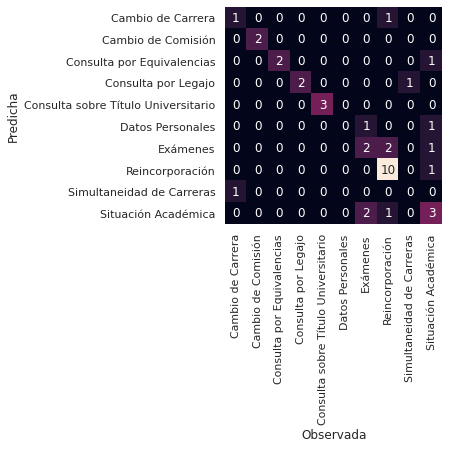

In [42]:
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

etiquetas = np.unique(y_test_cascada_2)

mat = metrics.confusion_matrix(y_test_cascada_2, y_pred_cascada_2)

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=etiquetas, yticklabels=etiquetas)

plt.xlabel('Observada')
plt.ylabel('Predicha');

### 3. Análisis del error

A continuación se intenta entender cuales el patrón del error para el modelo de 1 nivel.

Para ello, se genera el dataset con las clases y el conteo de frecuencia de instancias en train set.

In [58]:
count_train = train_df.clase.value_counts().sort_index()

df_error = pd.DataFrame(count_train).reset_index()
df_error.columns = ['clase', 'count_train']
df_error

,clase,count_train
0,Boleto Universitario,193
1,Cambio de Carrera,11
2,Cambio de Comisión,8
3,Consulta por Equivalencias,10
4,Consulta por Legajo,15
5,Consulta sobre Título Universitario,10
6,Cursadas,75
7,Datos Personales,6
8,Exámenes,18
9,Ingreso a la Universidad,135


Incorporo el accuracy por clase y el conteo de frecuencia para test set:

In [62]:
#df_error = df_train_e.groupby(['clase']).reset_index()

# Accuracy por clase
avg_class = mat_clf.diagonal()/mat_clf.sum(axis=1)
df_error['accuracy'] = pd.Series(avg_class)

df_error['count_test'] = mat_clf.sum(axis=1)

df_error

,clase,count_train,accuracy,count_test
0,Boleto Universitario,193,0.979167,48
1,Cambio de Carrera,11,0.000000,2
2,Cambio de Comisión,8,0.000000,2
3,Consulta por Equivalencias,10,0.666667,3
4,Consulta por Legajo,15,0.666667,3
5,Consulta sobre Título Universitario,10,0.333333,3
6,Cursadas,75,0.894737,19
7,Datos Personales,6,0.000000,2
8,Exámenes,18,0.600000,5
9,Ingreso a la Universidad,135,0.787879,33


In [64]:
GUARDA_ACC = True

if GUARDA_ACC:
  from google.colab import drive
  drive.mount('drive')

  df_error.to_csv('accuracy_by_class-etiq_manual.csv', index=False)
  !cp accuracy_by_class-etiq_manual.csv "drive/My Drive/jaiio-prep/"

Mounted at drive


## Referencias
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- https://medium.com/analytics-vidhya/ml-pipelines-using-scikit-learn-and-gridsearchcv-fe605a7f9e05